In [1]:
# 模拟数据获取
from airplane import Airplane
from receiver import Receiver

airplane1 = Airplane('782034',[118.128234,33.2141348,10000],[120.86143245,34.750012,10000],180,0)
receiver1 = Receiver([108.7187911987,34.0290298462,435],dirfting=-500,NoiseRange=(-300,300))
receiver2 = Receiver([108.7135726929,34.0363121033,427],dirfting=500,NoiseRange=(-300,300))
receiver3 = Receiver([118.56588,34.448925,500])
time_track1 =receiver1.fin_time_track(airplane1)
time_track2 =receiver2.fin_time_track(airplane1)
time_track3 =receiver3.fin_time_track(airplane1)
track1 = airplane1.track

In [2]:
print(time_track1[:10])
print(time_track2[:10])
print(time_track3[:10])

[0.002919250262134057, 0.5744972862076322, 1.1486461464013762, 1.6935216586287658, 2.097168313883977, 2.613101438233718, 3.0458877483821443, 3.5315330534085794, 3.976620112893716, 4.399420420185049]
[0.002920931139512754, 0.5744994365588233, 1.1486489518177658, 1.6935249234087575, 2.097172305393095, 2.6131061722705207, 3.0458926535755153, 3.5315382814304255, 3.976626075371326, 4.399426246960234]
[0.0004779764237391198, 0.5720564662610953, 1.1462052485325942, 1.691080966969408, 2.0947277785676777, 2.6106607987544304, 3.0434468295742434, 3.5290925856085886, 3.974179188876447, 4.396979316702463]


3395 3395


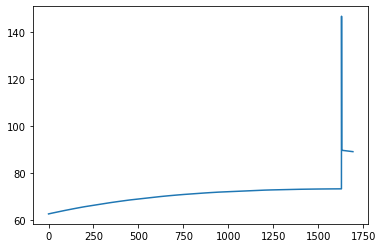

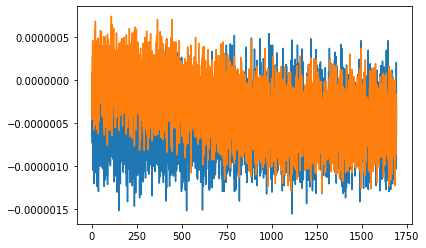

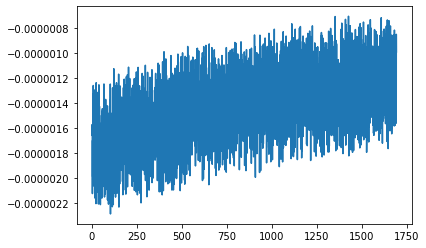

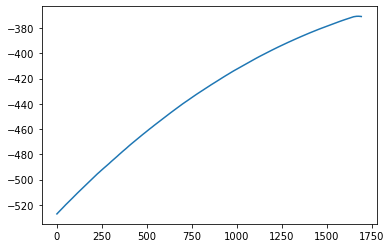

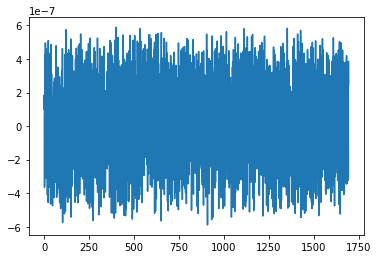

In [3]:
# 获取前后数据包时间差
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pi, atan


time_error1 = []
time_error2 = []
time_error3 = []

dirft12 = []
dirft13 = []

location_error = []

TDOA = []

ddoa = []

yu = []
print(len(track1),len(time_track1))

for i in range(len(time_track1)-1):
    time_error1.append(time_track1[i+1]-time_track1[i]-50000000)#-(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))*10/3)
    time_error2.append(time_track2[i+1]-time_track2[i]-50000000)#-(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))*10/3)
    time_error3.append(time_track3[i+1]-time_track3[i]-50000000)#-(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))*10/3)

    dirft12.append(time_error1[i]-time_error2[i])
    dirft13.append(time_error1[i]-time_error3[i])
    
    location_error.append(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))
    
    TDOA.append(time_track1[i+1]-time_track2[i+1] + 1000*time_track1[i+1]/1000000000)
    
    ddoa.append(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i+1],receiver2.location))
#     print(airplane1.geodistance(track1[i+1],receiver1.location),airplane1.geodistance(track1[i+1],receiver2.location))
    yu.append(TDOA[i] - ddoa[i]/300000000)
    
    
    
    
# plt.plot(using_data[19:79], test_data[19:79])

# plt.ylim(0.39,0.6)
# plt.xlim(0.39,0.6)
plt.plot(time_track1[:-1], location_error)
plt.show()

plt.plot(time_track1[:-1], dirft12)
plt.plot(time_track1[:-1], dirft13)
plt.show()

plt.plot(time_track1[:-1], TDOA)
plt.show()

plt.plot(time_track1[:-1], ddoa)
plt.show()

plt.plot(time_track1[:-1], yu)
plt.show()

No handles with labels found to put in legend.


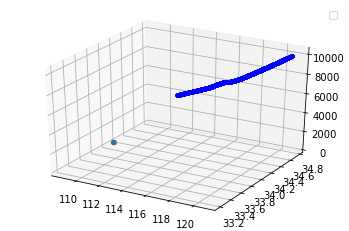

In [7]:
 fig = plt.figure()
ax = fig.gca(projection='3d')


lng = []
lat = []
high = []
for position in track1:
    lng.append(position[0])
    lat.append(position[1])
    high.append(position[2])
ax.plot(lng, lat, high, 'b.')
ax.scatter(receiver1.location[0], receiver1.location[1], receiver1.location[2], 'r.')
ax.scatter(receiver2.location[0], receiver2.location[1], receiver2.location[2], 'r.')
ax.legend()
plt.show()       

In [18]:
 print(airplane1.geodistance(receiver2.location,receiver1.location))

941.8099777428565


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.autograd.Variable as Variable

use_gpu = True

class CharRNN(nn.Module):
    def __init__(self, num_classes, embed_dim, hidden_size, 
                 num_layers, dropout):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.word_to_vec = nn.Embedding(num_classes, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_size, num_layers, dropout)
        self.project = nn.Linear(hidden_size, num_classes)

    def forward(self, x, hs=None):
        batch = x.shape[0]
        if hs is None:
            hs = Variable(
                torch.zeros(self.num_layers, batch, self.hidden_size))
            if use_gpu:
                hs = hs.cuda()
        word_embed = self.word_to_vec(x)  # (batch, len, embed)
        word_embed = word_embed.permute(1, 0, 2)  # (len, batch, embed)
        out, h0 = self.rnn(word_embed, hs)  # (len, batch, hidden)
        le, mb, hd = out.shape
        out = out.view(le * mb, hd)
        out = self.project(out)
        out = out.view(le, mb, -1)
        out = out.permute(1, 0, 2).contiguous()  # (batch, len, hidden)
        return out.view(-1, out.shape[2]), h0